In [61]:
# ==============================
# Standard Library Imports
# ==============================
from enum import Enum
import random

# ==============================
# Third-party Library Imports
# ==============================
import numpy as np  # Original numpy
import pennylane as qml
import scipy as sp

# Pennylane numpy
from pennylane import numpy as pnp 

In [62]:
# ==============================
# Setup for Quantum Computations
# ==============================

# PennyLane settings
dev = qml.device('default.mixed', wires=1)

In [63]:
# ==============================
# Global Variables
# ==============================
NUM_EVO = 0

In [64]:
def hamiltonian(coeff_x, coeff_y):
    coeffs = [coeff_x * 0.5, coeff_y * 0.5, 1 * 0.5]
    rot = [qml.PauliX(0), qml.PauliY(0), qml.PauliZ(0)]
    
    return qml.Hamiltonian(coeffs = coeffs, observables = rot)

$$
H = 
coeff_{x} \cdot(X_0) + coeff_{y} \cdot(Y_0) + 1 \cdot(Z_0)
$$

In [65]:
@qml.qnode(dev)
def circuit(coeff_parameters, dt):
    global NUM_EVO
    for evo_idx in range(NUM_EVO):
        coeff_x = coeff_parameters[0 + evo_idx * 2]     # 0, 2, 4, 6 ...    x민
        coeff_y = coeff_parameters[1 + evo_idx * 2]     # 1, 3, 5, 7 ...    y만
        get_hamiltonian = hamiltonian(coeff_x, coeff_y)
        
        qml.ApproxTimeEvolution(get_hamiltonian, dt, 1)
    
    return qml.density_matrix(wires=0)

In [66]:
from math import *

@qml.qnode(dev)
def hadamard_test():
    qml.Hadamard(wires=0)
    
    return qml.density_matrix(wires=0)

def fidelity(rho_1, rho_2):
    stage_1 = sp.linalg.sqrtm(
        sp.linalg.sqrtm(rho_1) @ rho_2 @ sp.linalg.sqrtm(rho_1)
    )
    
    return np.trace(stage_1)

# x-rotation operater
def Rx(theta):
    return np.matrix([  [cos(theta/2),  -1j*sin(theta/2)],
                        [-1j*sin(theta/2),  cos(theta/2)]])

# z-rotation operater
# Control by rotation only by Hamiltonian.
def Rz(phi): 
    return np.matrix([  [cos(phi/2)-1j*sin(phi/2),  0],
                        [0,  cos(phi/2)+1j*sin(phi/2)]])

def cost_function(paras):
    # print(paras)
    # print(paras[:-1])
    # print(paras[-1])
    
    coeff_parameters = paras[:-1]
    dt = paras[-1]
    
    rho_1 = circuit(coeff_parameters, dt)
    # rho_2 = hadamard_test().numpy()
    
    # making rho
    init_wave = np.array([[1], [0]])
    irho_init = np.kron(init_wave,init_wave.conj().T)
    target_U = Rz(2.999853842) @ Rx(1.157343739)
    rho_2 = target_U @ irho_init @ target_U.conj().T

    
    cal_fidelity = fidelity(rho_1, rho_2).real
    
    return -cal_fidelity

def get_prev_sequence_len():
    # gets a sequence obtained from a*
    example_sequence = [3, 3, 2, 2, 4, 4, 1, 1, 3, 3, 2]
    
    get_length = len(example_sequence)
    
    return get_length

In [67]:
NUM_EVO = get_prev_sequence_len()       # set number of time-evo
initial_paras = [0, 0] * NUM_EVO + [3]  # [coeff_x0, coeff_y1], ... [dt]

constraints = [
    # coeff_x
    (-1.5, 1.5),
    # coeff_y
    (-1.5, 1.5),
] * NUM_EVO + [
    # dt
    (0, 7)
]

result = sp.optimize.minimize(
    fun = cost_function, 
    x0 = initial_paras,
    method = 'L-BFGS-B',
    bounds = constraints,
    tol = 1e-12,
    options={
        'ftol': 1e-12, 
        'gtol': 1e-12
        }
    )

In [68]:
def print_result(result):
    global NUM_EVO
    print("Optimized_fidelity =", f"{-result.fun:.4f}",'\n')

    for i in range(NUM_EVO):
        print(f"num_evo: {i+1}")
        print(f"[coeff_x, coeff_y, dt] = [{result.x[0 +i*2]:.4f}, {result.x[1 +i*2]:.4f}, {result.x[-1]:.4f}]\n")
        # print(f"[dt] = {result.x[0 +i*3]:.4f}\n")

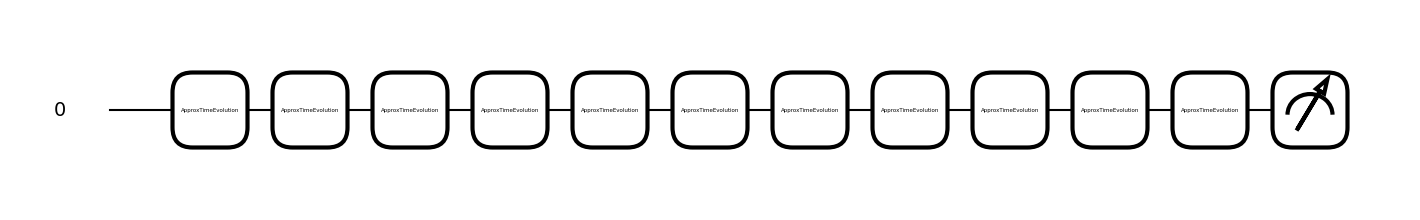

In [69]:
null = [1,1] * NUM_EVO + [1]
fig, ax = qml.draw_mpl(circuit)(null, null[-1])

In [70]:
print_result(result)

Optimized_fidelity = 0.9999 

num_evo: 1
[coeff_x, coeff_y, dt] = [0.1199, 0.8273, 3.0338]

num_evo: 2
[coeff_x, coeff_y, dt] = [-0.2082, -0.7760, 3.0338]

num_evo: 3
[coeff_x, coeff_y, dt] = [0.3353, 0.7549, 3.0338]

num_evo: 4
[coeff_x, coeff_y, dt] = [-0.4520, -0.6159, 3.0338]

num_evo: 5
[coeff_x, coeff_y, dt] = [0.5673, 0.6602, 3.0338]

num_evo: 6
[coeff_x, coeff_y, dt] = [-0.6169, -0.5007, 3.0338]

num_evo: 7
[coeff_x, coeff_y, dt] = [0.7228, 0.4336, 3.0338]

num_evo: 8
[coeff_x, coeff_y, dt] = [-0.7560, -0.3322, 3.0338]

num_evo: 9
[coeff_x, coeff_y, dt] = [0.8062, 0.2850, 3.0338]

num_evo: 10
[coeff_x, coeff_y, dt] = [-0.8195, -0.1331, 3.0338]

num_evo: 11
[coeff_x, coeff_y, dt] = [0.8466, 0.0092, 3.0338]

